Import Libraries

In [2]:
# Importing necessary libraries for data manipulation, visualization, and model training
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from wordcloud import WordCloud
import scipy.sparse as sp
import nltk
from collections import Counter
from nltk import ngrams
from itertools import chain
import joblib

In [3]:
# Ensure necessary NLTK resources are downloaded (used for tokenization and lemmatization)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\igorv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\igorv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\igorv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Data Collection and Exploration

In [5]:
# Loading datasets for real and fake news articles
real_news = pd.read_csv('True.csv')
fake_news = pd.read_csv('Fake.csv')

# Labeling datasets
real_news['label'] = 1
fake_news['label'] = 0

In [6]:
# Basic info on real news dataset
print("Real news info:")
print(real_news.info())
print(real_news.head())

Real news info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
 4   label    21417 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 836.7+ KB
None
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON

In [7]:
# Basic info on fake news dataset
print("\nFake news info:")
print(fake_news.info())
print(fake_news.head())


Fake news info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
 4   label    23481 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 917.4+ KB
None
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed 

In [8]:
# Checking for missing values in both datasets
print("\nMissing values in real news:")
print(real_news.isna().sum())

print("\nMissing values in fake news:")
print(fake_news.isna().sum())


Missing values in real news:
title      0
text       0
subject    0
date       0
label      0
dtype: int64

Missing values in fake news:
title      0
text       0
subject    0
date       0
label      0
dtype: int64


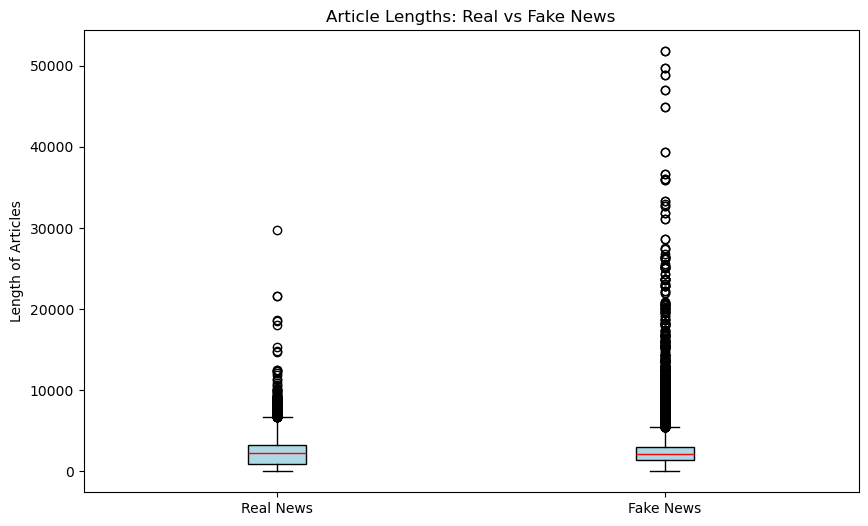

In [9]:
# Plotting article lengths for comparison
real_lengths = real_news['text'].apply(len)
fake_lengths = fake_news['text'].apply(len)

plt.figure(figsize=(10, 6))
plt.boxplot([real_lengths, fake_lengths], labels=['Real News', 'Fake News'], 
            patch_artist=True, boxprops=dict(facecolor='lightblue'), 
            medianprops=dict(color='red'))
plt.title('Article Lengths: Real vs Fake News')
plt.ylabel('Length of Articles')
plt.show()

Text Preprocessing: Cleaning, Tokenization, and Lemmatization

In [11]:
# Function to clean text: removes special characters and extra spaces, converts text to lowercase
def clean_text(text):
    text = re.sub(r'\W', ' ', text)  # Replaces non-alphanumeric characters with space
    text = re.sub(r'\s+', ' ', text)  # Replaces multiple spaces with a single space
    return text.lower()  # Converts text to lowercase

# Apply cleaning
real_news['clean_text'] = real_news['text'].apply(clean_text)
fake_news['clean_text'] = fake_news['text'].apply(clean_text)

# Displaying cleaned text samples
print("Real news cleaned text:")
print(real_news[['text', 'clean_text']].head())

print("\nFake news cleaned text:")
print(fake_news[['text', 'clean_text']].head())

Real news cleaned text:
                                                text  \
0  WASHINGTON (Reuters) - The head of a conservat...   
1  WASHINGTON (Reuters) - Transgender people will...   
2  WASHINGTON (Reuters) - The special counsel inv...   
3  WASHINGTON (Reuters) - Trump campaign adviser ...   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...   

                                          clean_text  
0  washington reuters the head of a conservative ...  
1  washington reuters transgender people will be ...  
2  washington reuters the special counsel investi...  
3  washington reuters trump campaign adviser geor...  
4  seattle washington reuters president donald tr...  

Fake news cleaned text:
                                                text  \
0  Donald Trump just couldn t wish all Americans ...   
1  House Intelligence Committee Chairman Devin Nu...   
2  On Friday, it was revealed that former Milwauk...   
3  On Christmas day, Donald Trump announced that ...   
4  P

In [12]:
# Function to tokenize text: splits text into individual words (tokens)
def tokenize_text(text):
    return word_tokenize(text)

# Apply tokenization
real_news['tokens'] = real_news['clean_text'].apply(tokenize_text)
fake_news['tokens'] = fake_news['clean_text'].apply(tokenize_text)

# Displaying tokenized samples
print("Real news tokens:")
print(real_news[['clean_text', 'tokens']].head())

print("\nFake news tokens:")
print(fake_news[['clean_text', 'tokens']].head())

Real news tokens:
                                          clean_text  \
0  washington reuters the head of a conservative ...   
1  washington reuters transgender people will be ...   
2  washington reuters the special counsel investi...   
3  washington reuters trump campaign adviser geor...   
4  seattle washington reuters president donald tr...   

                                              tokens  
0  [washington, reuters, the, head, of, a, conser...  
1  [washington, reuters, transgender, people, wil...  
2  [washington, reuters, the, special, counsel, i...  
3  [washington, reuters, trump, campaign, adviser...  
4  [seattle, washington, reuters, president, dona...  

Fake news tokens:
                                          clean_text  \
0  donald trump just couldn t wish all americans ...   
1  house intelligence committee chairman devin nu...   
2  on friday it was revealed that former milwauke...   
3  on christmas day donald trump announced that h...   
4  pope francis 

In [13]:
# Lemmatization: converting tokens to their base form, removing stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def lemmatize_text(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

# Apply lemmatization to both datasets
real_news['lemmatized_text'] = real_news['tokens'].apply(lemmatize_text)
fake_news['lemmatized_text'] = fake_news['tokens'].apply(lemmatize_text)

# Combine lemmatized tokens back into a single string for each article
real_news['processed_text'] = real_news['lemmatized_text'].apply(' '.join)
fake_news['processed_text'] = fake_news['lemmatized_text'].apply(' '.join)

# Display processed text samples
print("Real news:")
print(real_news[['text', 'processed_text']].head())

print("\nFake news:")
print(fake_news[['text', 'processed_text']].head())

Real news:
                                                text  \
0  WASHINGTON (Reuters) - The head of a conservat...   
1  WASHINGTON (Reuters) - Transgender people will...   
2  WASHINGTON (Reuters) - The special counsel inv...   
3  WASHINGTON (Reuters) - Trump campaign adviser ...   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...   

                                      processed_text  
0  washington reuters head conservative republica...  
1  washington reuters transgender people allowed ...  
2  washington reuters special counsel investigati...  
3  washington reuters trump campaign adviser geor...  
4  seattle washington reuters president donald tr...  

Fake news:
                                                text  \
0  Donald Trump just couldn t wish all Americans ...   
1  House Intelligence Committee Chairman Devin Nu...   
2  On Friday, it was revealed that former Milwauk...   
3  On Christmas day, Donald Trump announced that ...   
4  Pope Francis used his annua

N-gram Analysis

In [15]:
# Function to get the most frequent n-grams from the text (words occurring together)
def get_top_ngrams(texts, n_range=(1, 5), top_n=10):
    all_ngrams = Counter()  # Counter to keep track of n-grams frequencies
    
    # Splitting each text into words
    processed_texts = [text.split() for text in texts]
    
    for n in range(n_range[0], n_range[1] + 1):
        # Generating n-grams from the texts
        ngrams_generator = chain.from_iterable(ngrams(text, n) for text in processed_texts)
        all_ngrams.update(Counter(ngrams_generator))
        
    # Returning top n-grams
    return {' '.join(k): v for k, v in all_ngrams.most_common() if len(k) in range(n_range[0], n_range[1] + 1)}

# Function to print the most frequent n-grams
def print_top_ngrams(ngrams_dict, category, n_range=(1, 5), top_n=10):
    print(f"\nTop {top_n} N-grams for {category} News:")
    for n in range(n_range[0], n_range[1] + 1):
        print(f"\nTop {top_n} {n}-grams ({category} News):")
        ngrams_n = {ngram: count for ngram, count in ngrams_dict.items() if len(ngram.split()) == n}
        for ngram, count in list(ngrams_n.items())[:top_n]:
            print(f"{ngram}: {count}")

In [16]:
# Analyze n-grams for real news
real_ngrams = get_top_ngrams(real_news['processed_text'])
print_top_ngrams(real_ngrams, "Real")

# Analyze n-grams for fake news
fake_ngrams = get_top_ngrams(fake_news['processed_text'])
print_top_ngrams(fake_ngrams, "Fake")


Top 10 N-grams for Real News:

Top 10 1-grams (Real News):
said: 99062
trump: 54732
u: 47110
state: 37677
would: 31605
reuters: 28976
president: 28727
republican: 23007
year: 22622
government: 19992

Top 10 2-grams (Real News):
united state: 12215
donald trump: 10136
white house: 8419
washington reuters: 6674
president donald: 5930
north korea: 5659
new york: 4740
prime minister: 4206
u president: 3951
said statement: 3943

Top 10 3-grams (Real News):
president donald trump: 5858
president barack obama: 2959
u president donald: 2535
washington reuters u: 2398
reuters u president: 1191
white house said: 960
new york reuters: 845
elect donald trump: 834
president elect donald: 832
respond request comment: 801

Top 10 4-grams (Real News):
u president donald trump: 2535
reuters u president donald: 865
president elect donald trump: 832
washington reuters u president: 734
reuters president donald trump: 686
secretary state rex tillerson: 670
russian president vladimir putin: 611
prime minis

Sentiment Analysis Using TextBlob

In [18]:
# Function to analyze sentiment polarity: returns a value between -1 (negative) and 1 (positive)
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply sentiment analysis to both datasets
real_news['sentiment'] = real_news['processed_text'].apply(get_sentiment)
fake_news['sentiment'] = fake_news['processed_text'].apply(get_sentiment)

# Display sentiment analysis results
print("Real news with sentiment:")
print(real_news[['text', 'processed_text', 'sentiment']].head())

print("\nFake news with sentiment:")
print(fake_news[['text', 'processed_text', 'sentiment']].head())

Real news with sentiment:
                                                text  \
0  WASHINGTON (Reuters) - The head of a conservat...   
1  WASHINGTON (Reuters) - Transgender people will...   
2  WASHINGTON (Reuters) - The special counsel inv...   
3  WASHINGTON (Reuters) - Trump campaign adviser ...   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...   

                                      processed_text  sentiment  
0  washington reuters head conservative republica...   0.027671  
1  washington reuters transgender people allowed ...   0.082515  
2  washington reuters special counsel investigati...   0.127165  
3  washington reuters trump campaign adviser geor...   0.031498  
4  seattle washington reuters president donald tr...   0.036436  

Fake news with sentiment:
                                                text  \
0  Donald Trump just couldn t wish all Americans ...   
1  House Intelligence Committee Chairman Devin Nu...   
2  On Friday, it was revealed that former Milw

Keyword Detection Using TF-IDF

C:\Users\igorv\AppData\Local\Temp\ipykernel_39148\3551586438.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tfidf_top.values, y=tfidf_top.index, palette='viridis')


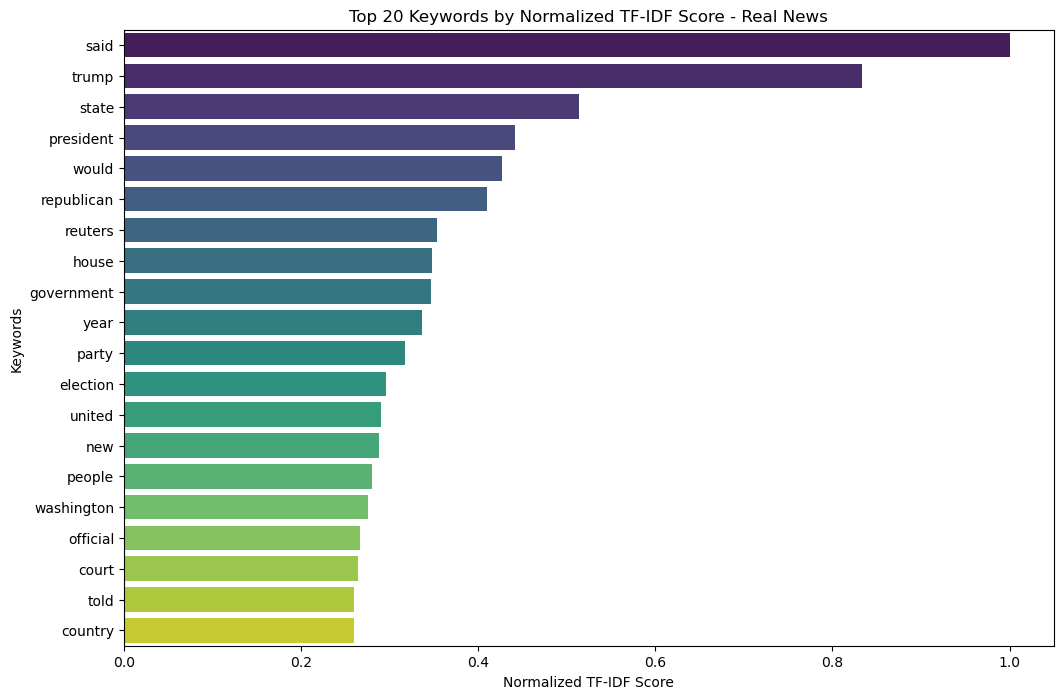

C:\Users\igorv\AppData\Local\Temp\ipykernel_39148\3551586438.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tfidf_top.values, y=tfidf_top.index, palette='viridis')


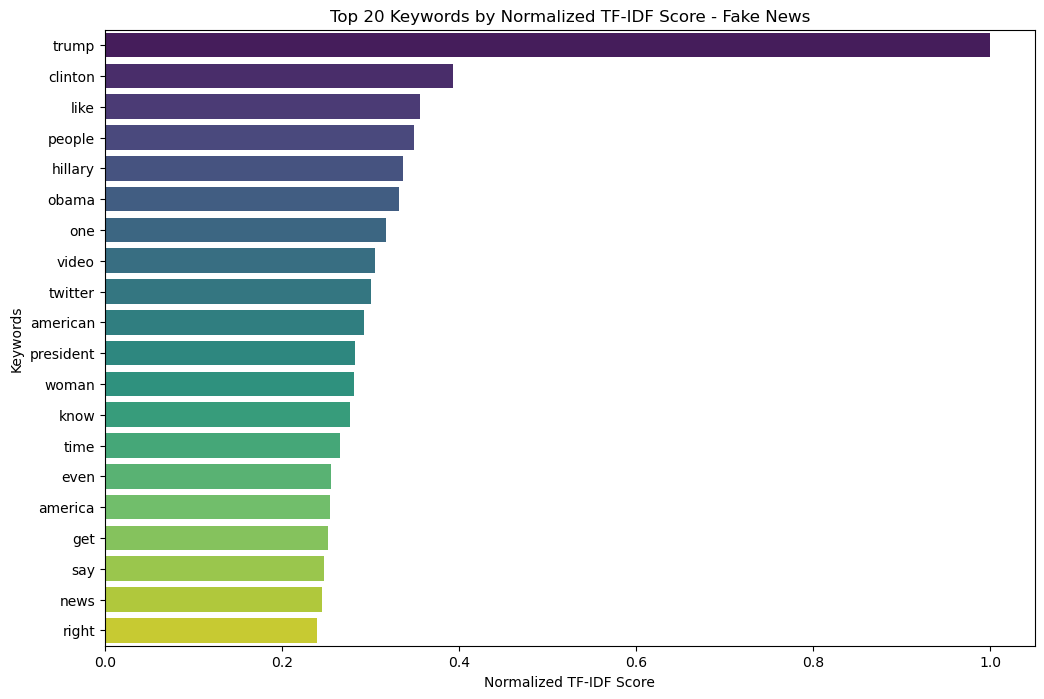

In [20]:
# TF-IDF (Term Frequency - Inverse Document Frequency) is a technique used to measure the importance of words in documents.
# Term Frequency (TF) measures how often a word appears in a document, while Inverse Document Frequency (IDF) 
# reduces the weight of words that occur frequently across many documents (like "and", "the", etc.).
# The goal is to highlight important words specific to a document and diminish those that are common and less significant.

# This technique helps identify which words stand out in a collection of texts, making it useful for 
# analyzing content and extracting important keywords. Normalizing the values to a range of 0 to 1 
# allows for easier comparison of results and highlights the most significant terms.

# TF-IDF (Term Frequency - Inverse Document Frequency) is used to measure the importance of words
tfidf = TfidfVectorizer(max_features=1000)  # Limit to the top 1000 most frequent words
tfidf_real = tfidf.fit_transform(real_news['processed_text'])
tfidf_fake = tfidf.transform(fake_news['processed_text'])

# Convert TF-IDF results into dataframes for better visualization
tfidf_real_df = pd.DataFrame(tfidf_real.toarray(), columns=tfidf.get_feature_names_out())
tfidf_fake_df = pd.DataFrame(tfidf_fake.toarray(), columns=tfidf.get_feature_names_out())

# Plotting top TF-IDF keywords with normalization
def plot_top_keywords(tfidf_df, title, top_n=20):
    tfidf_sum = tfidf_df.sum(axis=0)
    
    # Normalize the sum to be between 0 and 1
    tfidf_sum_normalized = tfidf_sum / tfidf_sum.max()
    
    tfidf_top = tfidf_sum_normalized.sort_values(ascending=False).head(top_n)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x=tfidf_top.values, y=tfidf_top.index, palette='viridis')
    plt.title(f'Top {top_n} Keywords by Normalized TF-IDF Score - {title}')
    plt.xlabel('Normalized TF-IDF Score')
    plt.ylabel('Keywords')
    plt.show()

# Plot top keywords for real and fake news
plot_top_keywords(tfidf_real_df, 'Real News')
plot_top_keywords(tfidf_fake_df, 'Fake News')

Generating and Visualizing WordCloud

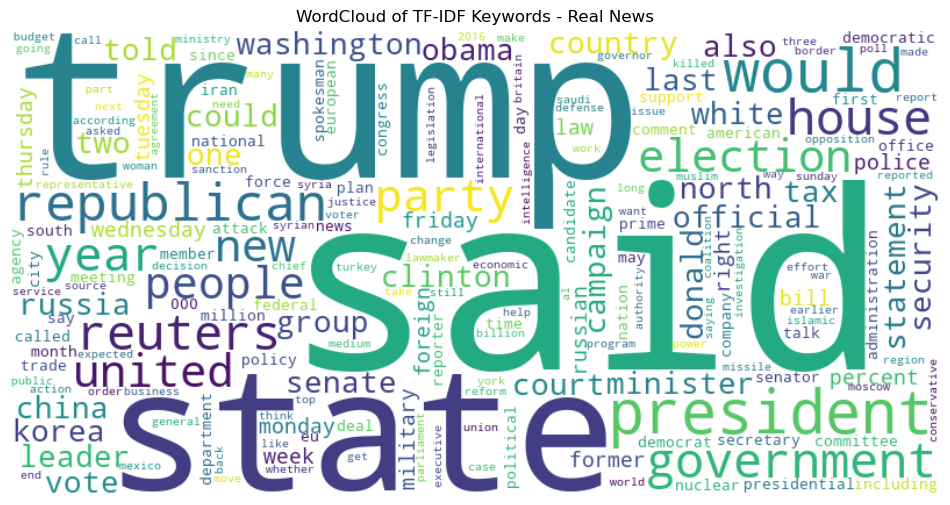

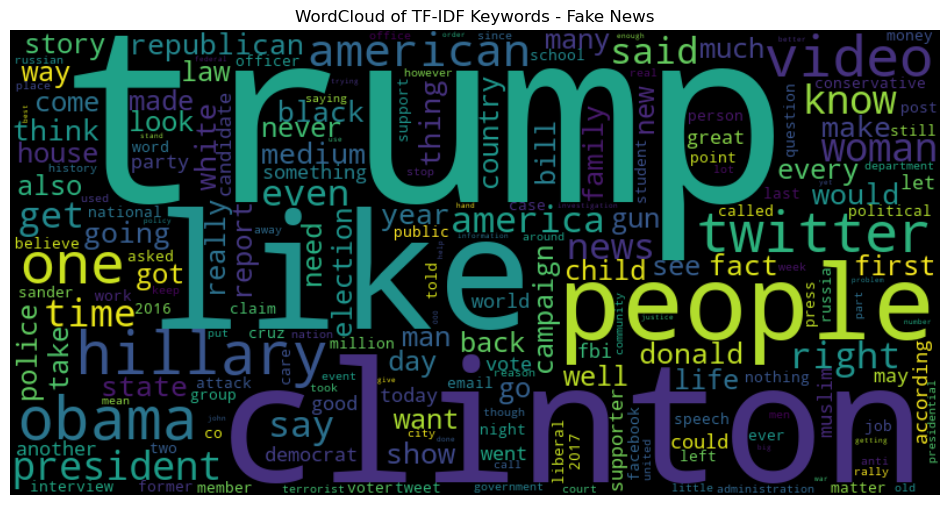

In [22]:
# Generate and display WordCloud for real news
tfidf_sum_real = tfidf_real_df.sum()
wordcloud_real = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_sum_real)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of TF-IDF Keywords - Real News')
plt.show()

# Generate and display WordCloud for fake news
tfidf_sum_fake = tfidf_fake_df.sum()
wordcloud_fake = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(tfidf_sum_fake)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of TF-IDF Keywords - Fake News')
plt.show()

Model Training and Evaluation

In [26]:
# Converts the text into a count of words (bag-of-words model)
# 'fit_transform' learns the words from 'real_news' and counts them
# 'transform' uses the same words to count in 'fake_news'
vectorizer = CountVectorizer()
X_real = vectorizer.fit_transform(real_news['processed_text'])
X_fake = vectorizer.transform(fake_news['processed_text'])

# Stacks the features from real and fake news into a single dataset for training
X = sp.vstack([X_real, X_fake])

# Concatenates labels: assigns 1 for each real news article and 0 for each fake news article
y = np.concatenate([np.ones(X_real.shape[0]), np.zeros(X_fake.shape[0])])

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training using Logistic Regression
model = LogisticRegression()
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Calculating and printing the evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

Accuracy: 0.9954
Precision: 0.9929
Recall: 0.9977
F1-score: 0.9953


Saving the Model

In [28]:
# Save the trained model to a file
joblib.dump(model, 'news_classification_model.pkl')

['news_classification_model.pkl']

Example Prediction

In [30]:
# Input a news article, which is then cleaned and processed
sample_text = input("Enter a news article text: ")
sample_processed = clean_text(sample_text)  # Preprocessing the input text
sample_vector = vectorizer.transform([sample_processed])  # Converting text into a vector format

# Model makes a prediction based on the vectorized input
prediction = model.predict(sample_vector)
print(f"Prediction: {'Real' if prediction[0] == 1 else 'Fake'}")  # Output is 'Real' or 'Fake' based on prediction

Enter a news article text:  Donald Trump just could not


Prediction: Fake
